In [37]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Loading the Pre-trained Model


In [38]:
model = VGG16(weights='imagenet')

# Step 2: Loading and Preprocessing the Input Image

In [39]:
img_path = '/content/lion.png'  # Replace this with the actual file path of the uploaded image

img = load_img(img_path, target_size=(224, 224))  # Resize to fit the model input
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


# Step 3: Predicting the Class of the Image


In [40]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
decoded_predictions = decode_predictions(predictions, top=1)[0][0]

print(f"Predicted Class: {decoded_predictions[1]} with Probability: {decoded_predictions[2]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
Predicted Class: lion with Probability: 1.0000


# Step 4: Computing Grad-CAM


In [41]:
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer("block5_conv3").output, model.output]
)

# Calculating the gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
pooled_grads = pooled_grads.numpy()
conv_outputs = conv_outputs.numpy()

for i in range(pooled_grads.shape[-1]):
    conv_outputs[:, :, i] *= pooled_grads[i]

heatmap = np.mean(conv_outputs, axis=-1)

# Normalizing the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


# Step 5: Visualizing the Heatmap


(-0.5, 13.5, 13.5, -0.5)

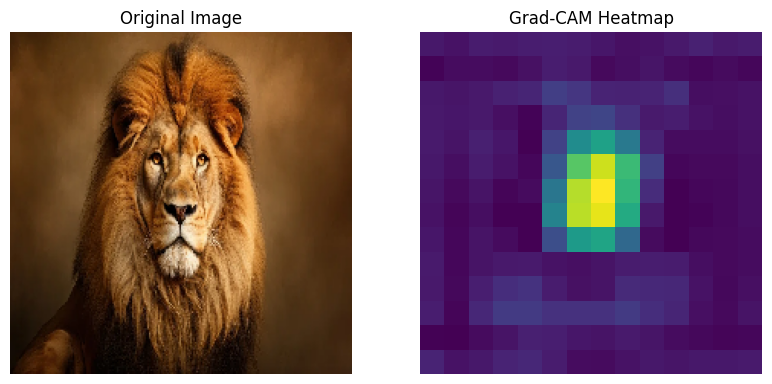

In [42]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="viridis")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Step 6: Displaying the Superimposed Heatmap


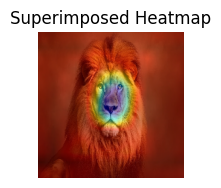

In [43]:
# Adding a channel dimension to the heatmap
heatmap_expanded = np.expand_dims(heatmap, axis=-1)
heatmap_resized = tf.image.resize(heatmap_expanded, (224, 224)).numpy()

# Removing the channel dimension after resizing
heatmap_resized = np.squeeze(heatmap_resized)
heatmap_colored = np.uint8(255 * heatmap_resized)

# Applying the colormap and create the superimposed image
heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(
    img_to_array(img).astype("uint8"), 0.6, heatmap_colored, 0.4, 0
)

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img / 255.0)
plt.title("Superimposed Heatmap")
plt.axis("off")

plt.show()